<a href="https://colab.research.google.com/github/FranklinBasilio/PyTorch/blob/master/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-youtube

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 133kB 8.1MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for stringcase: filename=stringcase-1.2.0-cp36-none-any.whl size=3578 sha256=95064796cd3234d76061a93e156e66c774a86f255ba1aed2061ee8e7c575c44a
  Stored in directory: /root/.cache/pip/wheels/a0/16/a0/16e2c81dbd47503b5a35583dfabde5a93b4cf98dbf0033dad5
Successfully built stringcase
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.10 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install dataclasses-json

In [ ]:
!pip install python-youtube

In [ ]:
from pyyoutube import Api

import skimage
from skimage import io, exposure
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
api_key='********'  # chave privada criada na conta google
api = Api(api_key = api_key)

Colate dos Dados

(180, 320, 3) 0.0 1.0
(180, 320, 3) 0.3137254901960784 1.0


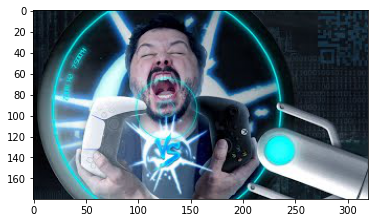

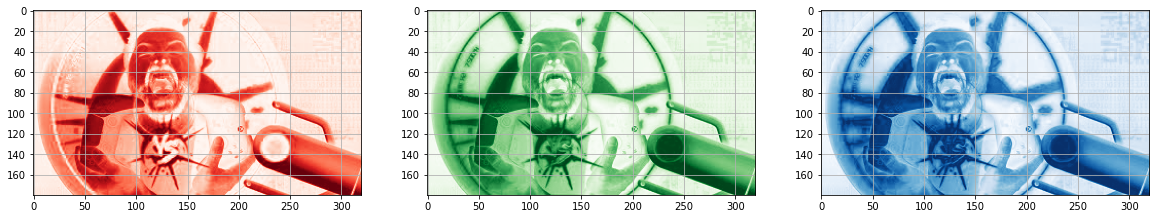

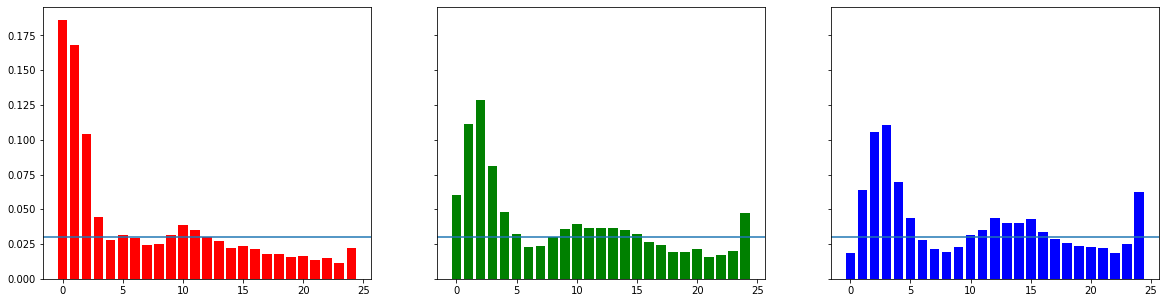

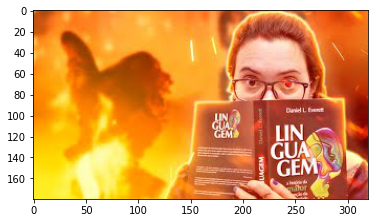

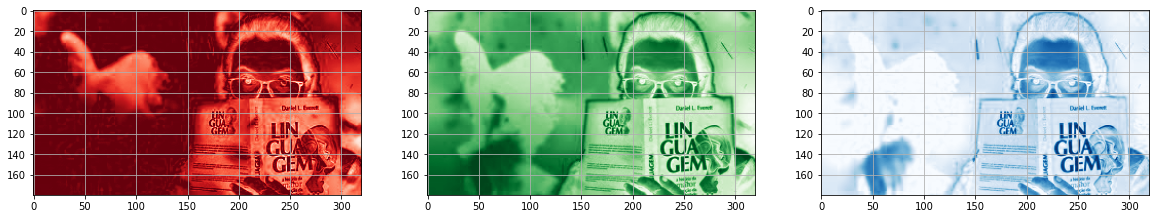

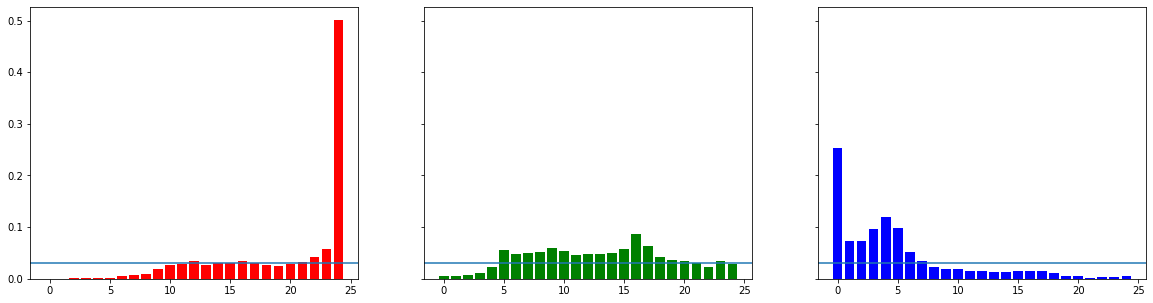

In [ ]:

#https://www.youtube.com/watch?v=Ua6B9RNT0o0 Nerdologia
#https://www.youtube.com/watch?v=P4-MRCRl7gM Peixe Babel

for url in ['Ua6B9RNT0o0','P4-MRCRl7gM']:  #código do video do tebato
  ## Acessando o link do thumbnail pela APPI do youtube
  video_by_id = api.get_video_by_id(video_id=url)
  thumbnail_url = video_by_id.items[0].to_dict()['snippet']['thumbnails']['medium']['url']

  ##lendo a imagem
  img = skimage.img_as_float(io.imread(thumbnail_url))
  plt.figure()
  plt.imshow(img)

  ## imprimindo canais separados da imagem (RGB-vermelho, verde, azul)
  print(img.shape, np.min(img[:,:,0]),np.max(img[:,:,0]))
  fig,axs=plt.subplots(1,3,figsize=(20,5))
  axs[0].imshow(img[:,:,0], cmap='Reds')
  axs[0].grid(True)
  axs[1].imshow(img[:,:,1], cmap='Greens')
  axs[1].grid(True)
  axs[2].imshow(img[:,:,2], cmap='Blues')
  axs[2].grid(True)

  ## Calculando e imprimindo os histogramas de cor
  nbins = 25
  histograms = [ exposure.histogram(img[:,:,i], nbins=nbins,normalize=True)[0] for i in range(img.shape[-1])]
  fig, axs = plt.subplots(1,3,figsize=(20,5),sharey=True)
  axs[0].bar(np.arange(len(histograms[0])),histograms[0],color='r')
  axs[0].axhline(0.03,0,50)
  axs[1].bar(np.arange(len(histograms[1])),histograms[1],color='g')
  axs[1].axhline(0.03,0,50)
  axs[2].bar(np.arange(len(histograms[2])),histograms[2],color='b')
  axs[2].axhline(0.03,0,50)
 

Coletando Thumbnails

In [ ]:
# Pegar os últimos 200 vídeos
channels = ['nerdologia', 'CanalPeixeBabel']
all_url = {}
all_histograms = {}

nbins = 25
for channel in channels:

  ## Acessando playlist principal do canal (uploads)
  channel_by_id = api.get_channel_info(channel_name=channel)
  playlist_uploads = channel_by_id.items[0].to_dict()['contentDetails']['relatedPlaylists']['uploads']

  ## Coletando o id dos últimos ## 200 ## vídeos de cada canal (count)
  playlist_item_by_playlist = api.get_playlist_items(playlist_id=playlist_uploads, count=200)
  len(playlist_item_by_playlist.items)
  
  all_url[channel] = []
  all_histograms[channel] = []
  
  for k, item in enumerate(playlist_item_by_playlist.items):
    try:
      ## Coletando informação da thumbnail de cada vídeo
      video_id = item.snippet.resourceId.videoId
      video_by_id = api.get_video_by_id(video_id=video_id)
      
      thumbnail_url = video_by_id.items[0].to_dict()['snippet']['thumbnails']['medium']['url']
      
      ## Lendo a imagem e extraindo os histogramas
      img = skimage.img_as_float(io.imread(thumbnail_url))
      histograms = [exposure.histogram(img[:,:,i], nbins=nbins, normalize=True)[0] for i in range(img.shape[-1])]
      all_histograms[channel].append(histograms)

      all_url[channel].append(thumbnail_url)
    except:
      print(k)

/usr/local/lib/python3.6/dist-packages/dataclasses_json/core.py:171: RuntimeWarning: `NoneType` object value of non-optional type allowed detected when decoding RegionRestriction.
  warnings.warn(f"`NoneType` object {warning}.", RuntimeWarning)


In [ ]:
np.savez_compressed('histograms',hist=all_histograms)
np.savez_compressed('thumbnail_url',url=all_url)

In [ ]:
all_url.keys()
url_list=[]
url_list.extend(all_url['nerdologia'])
url_list.extend(all_url['CanalPeixeBabel'])

label_list = len(all_url['nerdologia'])*[0]
label_list.extend(len(all_url['CanalPeixeBabel'])*[1])

len(url_list),len(label_list)

(400, 400)

In [ ]:
##Criando um dataset
import torch
from torch import nn, optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
class ThumbData(Dataset):
  def __init__(self, all_url, label_list, nbins):
    self.all_url = all_url
    self.nbins   = nbins
    self.labels  = label_list

  def __len__(self):
    return len(self.all_url)

  def __getitem__(self, idx):

    thumbnail_url = self.all_url[idx]
    img = skimage.img_as_float(io.imread(thumbnail_url))

    histograms = [exposure.histogram(img[:,:,i], nbins=self.nbins, normalize=True)[0] for i in range(img.shape[-1])]

    return np.asarray(histograms).ravel(), self.labels[idx]

data = ThumbData(url_list, label_list, nbins)

train_size = int(0.75*len(data))
idx  = torch.randperm(len(data))
train_sampler = SubsetRandomSampler(idx[0:train_size]) 
test_sampler = SubsetRandomSampler(idx[train_size:])

train_loader = DataLoader(data, sampler=train_sampler,
                          batch_size=10, num_workers=4)

test_loader  = DataLoader(data, sampler=test_sampler,
                          batch_size=10, num_workers=4)

In [ ]:
## Implementando a rede neural em PyTorch

class MinhaRede(nn.Module):

  def __init__(self, tam_entrada):

    super(MinhaRede, self).__init__()

    # Definir a arquitetura
    self.rede = nn.Sequential(
        nn.Linear(tam_entrada, 32),
        nn.ReLU(),
        nn.Linear(32, 2)
    )

  def forward(self, thumbnail):

    # Fluxo de passagem do dado
    saida = self.rede(thumbnail)
    return saida

tam_entrada = 3 * 25
#rede = MinhaRede(tam_entrada).cuda()
rede = MinhaRede(tam_entrada).to(device).double()

print(rede)


MinhaRede(
  (rede): Sequential(
    (0): Linear(in_features=75, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [ ]:
## Loss e Otimizador
optimizer = optim.Adam(rede.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
## Fluxo de Treinamento
from sklearn import metrics 

def forward(mode, loader):

  if mode == 'train':
    rede.train()
  else:
    rede.eval()
  
  epoch_loss = []
  pred_list, label_list = [], []

  for data, label in loader:

    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    out = rede(data)
    # print(out.size(), label.size())
    loss = criterion(out, label)
    epoch_loss.append(loss.cpu().data)
  
    pred = out.data.max(dim=1)[1].cpu().numpy()
    # print(label)
    pred_list.append(pred)
    label_list.append(label.cpu().numpy())

    if mode == 'train':
      loss.backward()
      optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  pred_list = np.asarray(pred_list).ravel()
  label_list = np.asarray(label_list).ravel()

  acc = metrics.accuracy_score(pred_list, label_list)

  print(mode, 'Loss:', epoch_loss.mean(), '+/-', epoch_loss.std(), 'Accuracy:', acc)

In [ ]:
num_epochs = 20
for i in range(num_epochs):
  forward('train', train_loader)
  forward('test', test_loader)
  print('--------------------------------')

train Loss: 0.687358229249916 +/- 0.03435851407937926 Accuracy: 0.5133333333333333
test Loss: 0.6814641797847893 +/- 0.025735925216910944 Accuracy: 0.46
--------------------------------
train Loss: 0.6587822237569989 +/- 0.028763229618396866 Accuracy: 0.55
test Loss: 0.637171859421309 +/- 0.015814158557707708 Accuracy: 0.85
--------------------------------
train Loss: 0.6109378298590443 +/- 0.031131537829075812 Accuracy: 0.8866666666666667
test Loss: 0.5689144673866856 +/- 0.024161665138773256 Accuracy: 0.93
--------------------------------
train Loss: 0.5452940762915638 +/- 0.03676920381652868 Accuracy: 0.9033333333333333
test Loss: 0.48469540240719305 +/- 0.03216226798382588 Accuracy: 0.92
--------------------------------
train Loss: 0.4719331433085767 +/- 0.04527456220314473 Accuracy: 0.89
test Loss: 0.40232923107041463 +/- 0.05264796604379038 Accuracy: 0.93
--------------------------------
train Loss: 0.4075154530788679 +/- 0.07714900869651796 Accuracy: 0.9066666666666666
test Loss

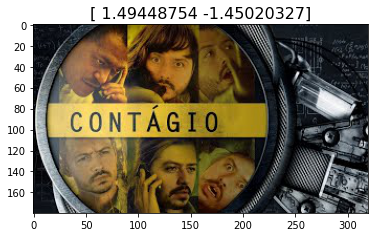

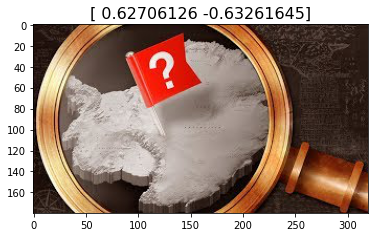

In [ ]:
## Predição

def predict(url):

  img = skimage.img_as_float(io.imread(url))
  plt.figure()
  plt.imshow(img)

  histograms = [exposure.histogram(img[:,:,i], nbins=nbins, normalize=True)[0] for i in range(img.shape[-1])]

  data = np.asarray(histograms).ravel()
  data = torch.Tensor(data).double().to(device)

  out = rede(data)
  plt.title(str(out.detach().cpu().numpy()), fontsize=16)
  plt.show()


peixebabel = url_list[idx[-2]]
predict(peixebabel)
nerdologia = url_list[idx[-149]]
predict(nerdologia)